In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import unittest
from discretize.utils import meshutils
import inspect
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, LinearNDInterpolator
from SimPEG.Utils import mkvc, modelutils
from scipy.spatial import cKDTree
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.spatial import Delaunay
import pyvista
from pyvista import examples
pyvista.set_plot_theme('document')

In [3]:
pyvista.rcParams['use_panel'] = False

In this example, we demonstrate different mesh refinement strategies available for TreeMesh under the Utils.
First let's define a simple ground survey and topography.

In [ ]:
def compute_bounds(bounds, factor):
    # Define a region of interest
    bounds = list(bounds) # COPY IT
    delta = np.array([np.abs(bounds[1] - bounds[0]),
                      np.abs(bounds[3] - bounds[2]),
                      np.abs(bounds[5] - bounds[4])])
    cushion = delta * factor
    bounds[::2] += cushion
    bounds[1::2] -= cushion
    return bounds

# Grab an awesome topography surface from vtki's example data
surface = examples.download_st_helens()
surface = surface.clip_box(compute_bounds(surface.bounds, 0.1), False).warp_by_scalar()
# Get the topography XYZ points
topo = surface.points
# surface.plot()

In [ ]:
bounds = compute_bounds(surface.bounds, 0.1)
# roi = vtki.Box(bounds).outline()
# vtki.plot([roi, surface])

In [ ]:
def make_survey(bounds, topo):
    # Create lines of observation points
    xr = np.linspace(bounds[0], bounds[1], 5)
    yr = np.linspace(bounds[2], bounds[3], 50)
    X, Y = np.meshgrid(xr, yr)
    xyz = np.c_[X.reshape(-1), Y.reshape(-1)]
    # Drape the lines to our topography
    F = LinearNDInterpolator(topo[:, :2], topo[:,-1])
    xyz = np.c_[xyz, F(xyz) + 1.]
    return xyz

xyz = make_survey(bounds, topo)
survey = vtki.PolyData(xyz)

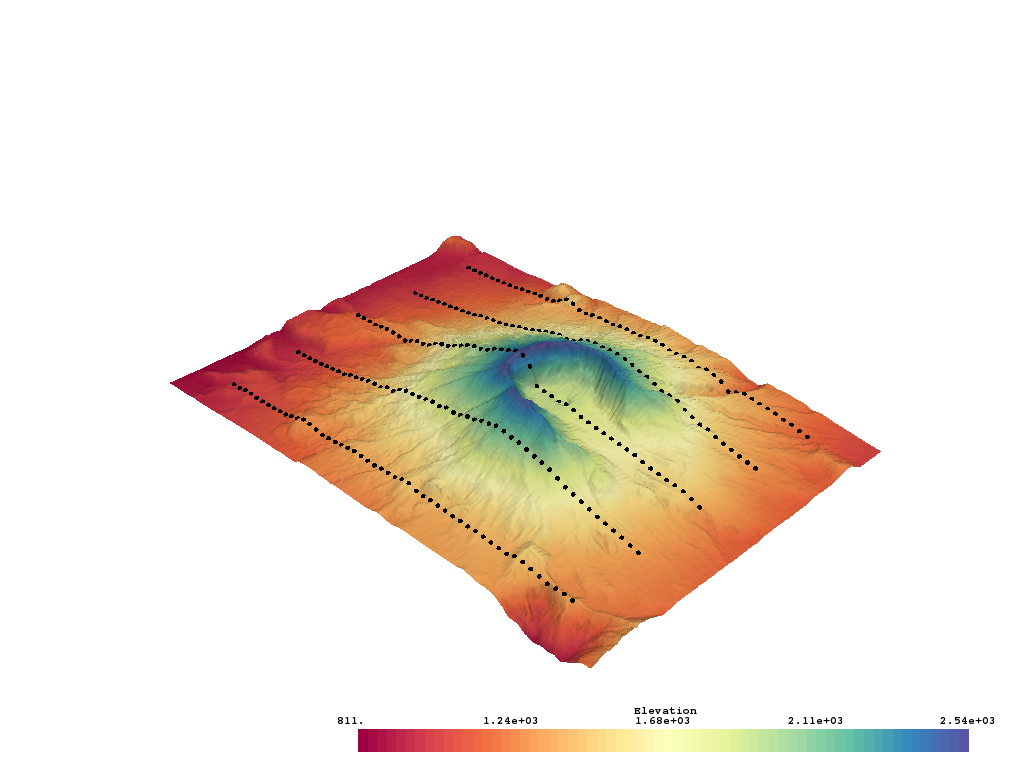

In [6]:
# Vis the survey on the topo
plotter = vtki.Plotter()
plotter.add_mesh(surface, cmap=plt.cm.Spectral)
plotter.add_mesh(survey, color='k', render_points_as_spheres=True)
plotter.show()

# Refine with point

In [7]:
np.unique(xyz[:,0]).tolist()



[559691.0, 561263.0, 562835.0, 564407.0, 565979.0]

In [8]:
def plot_vtki(mesh, model, actv, interactive=False, 
              clim=None, cmap='cubehelix', screenshot=False,
              scalar_name='log(Volume)', cpos=None, figure_name='figure'):
    # Convert TreeMesh to VTK
    dataset = mesh.toVTK()
    # Add data values to mesh cells
    dataset.cell_arrays[scalar_name] = model
    dataset.cell_arrays['Active'] = actv
    dataset.active_scalar_name = scalar_name
    
    # Remove the inactive cells
    threshed = dataset.threshold(0.5, scalars='Active')
    
    #### Plotting Routine ####
    # Plotting paramaters for data on mesh
    d_params = dict(
            show_edges=False,
            cmap=cmap,
            scalars='log(Volume)',
            clim=clim,
        )
    
    # Instantiate plotting window
    plotter = vtki.Plotter(notebook=not interactive)
    
    # Show axes labels
    plotter.show_grid(all_edges=False,)
    
    # Add a bounding box of original mesh to see total extent
    plotter.add_mesh(dataset.outline(), color='k')
    plotter.add_mesh(survey, color='k', render_points_as_spheres=True)
    # Show input surface topography
    rng = list(surface.get_data_range())
    rng[0] -= (rng[1] - rng[0])/1.5
#     plotter.add_mesh(surface, cmap='gray', clim=rng, opacity=.25)
    
    origin = threshed.center
#     origin[1] = 5116959 # change the Y location

    # Clip volume in half
    plotter.add_mesh(threshed.clip('y', np.r_[origin[0], 5116959, origin[2]] ), **d_params)

    # Add all the slices
#     slices = threshed.slice_along_axis(n=7, axis='x')
#     plotter.add_mesh(slices, name='slices', **d_params)
    for xx in np.unique(xyz[:,0]).tolist():
#         single_slice = 
        plotter.add_mesh(threshed.slice('x', np.r_[xx, origin[1], origin[2]]), name='slice %i'%xx, **d_params)
    
#     origin[1] = 5118959
    single_slice = threshed.slice('y', np.r_[origin[0], 5118959, origin[2]])
    plotter.add_mesh(single_slice, name='single_slice', **d_params)

    # Show the mesh resolution at the surface
    # plotter.add_mesh(dataset.wireframe(), opacity=0.5, **d_params)
    
    # TODO: Add the vectors

    # Show camera position
    if cpos is None:
        # use nice default position:
        cpos =[# Location:
               (567924.1677315354, 5127308.444057624, 8812.044269432197),
               # Focus/center
               (561954.3118572216, 5116606.320433859, 475.21385977302384),
               # Viewup
               (-0.26532327356494306, -0.4960409150961258, 0.8267689949770617)
              ]
        
    plotter.camera_position = cpos
    plotter.show(auto_close=False)
    plotter.export_vtkjs(figure_name)
    plotter.close()

#     return plotter.show(screenshot=screenshot)



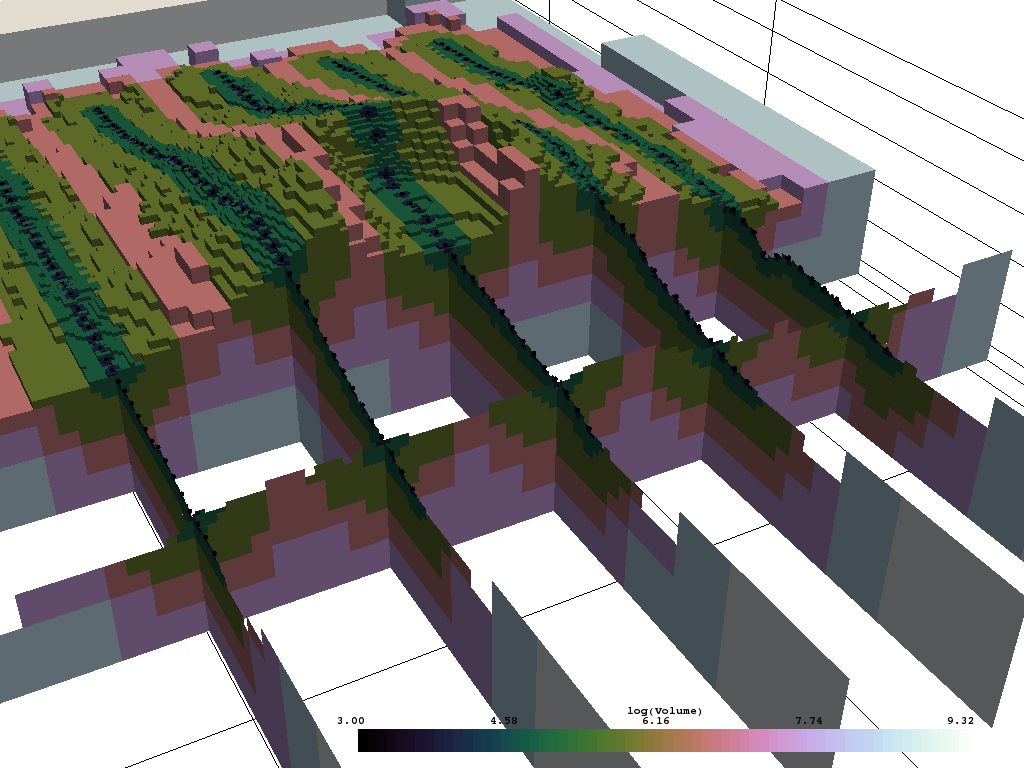

Finished exporting dataset to:  figure.vtkjs


In [10]:
# Create a mesh based on data extent
mesh = meshutils.mesh_builder_xyz(
    topo, [10, 10, 10],
    depth_core=500,
    padding_distance=[[0, 0], [0, 0],[0, 0]],
    mesh_type='TREE',
)

mesh = meshutils.refine_tree_xyz(mesh, xyz, 
                                 octree_levels=[1,3,4,5], 
                                 method='radial', finalize=True)

indTopo = modelutils.surface2ind_topo(mesh, topo, gridLoc='CC')

plot_vtki(mesh, np.log10(mesh.vol), indTopo, ) # add interactive=True  to chose the viewinteractive=True

# Refine on triangulated surface from points

In [11]:
# Create a mesh based on data extent
mesh = meshutils.mesh_builder_xyz(
    topo, [10, 10, 10],
    depth_core=50,
    mesh_type='TREE',
)
mesh = meshutils.refine_tree_xyz(mesh, topo, 
                                 octree_levels=[0, 0, 1], 
                                 method='surface', finalize=False,
                                )

mesh = meshutils.refine_tree_xyz(mesh, xyz, 
                                 octree_levels=[10, 10], 
                                 method='radial', finalize=True,
                                )
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Y', ind=63, grid=True, pcolorOpts={"cmap":"plasma"})

indTopo = modelutils.surface2ind_topo(mesh,topo, gridLoc='CC')
# actv = np.zeros(mesh.nC)
# actv[indTopo] = 1

# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Y', ind=int(np.searchsorted(mesh.vectorCCy, 50)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# ax.set_aspect('equal')



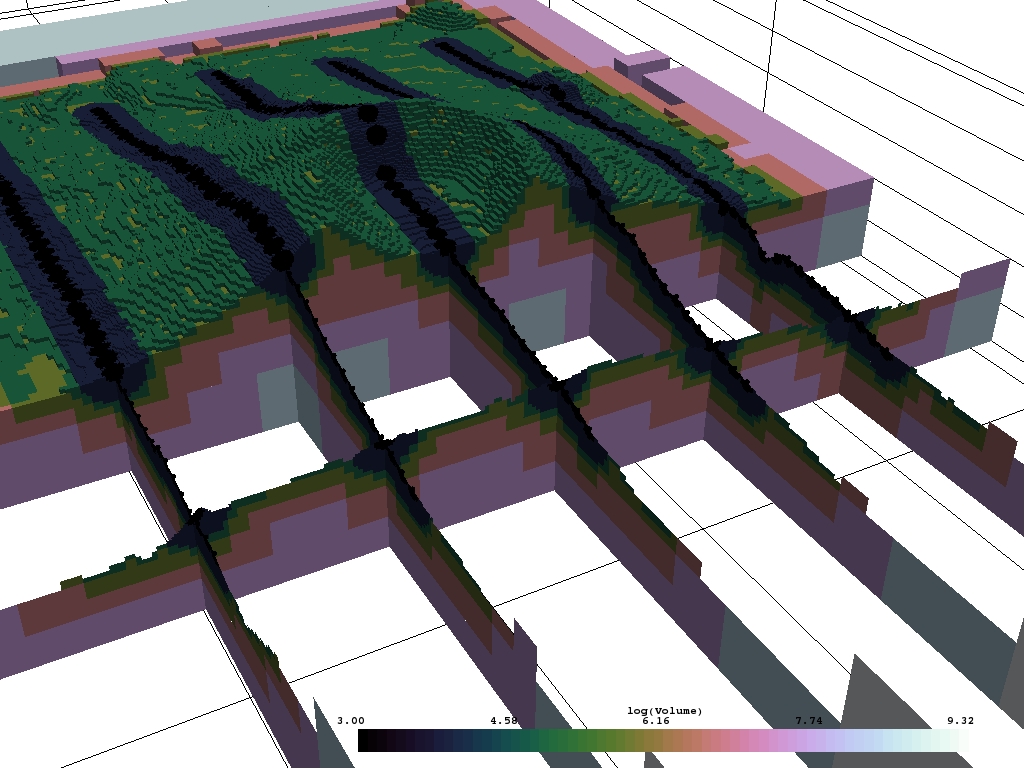

Finished exporting dataset to:  figure.vtkjs


In [61]:
plot_vtki(mesh, np.log10(mesh.vol), indTopo)

# Refine inside box

In [ ]:
# Create a mesh based on data extent
mesh = meshutils.mesh_builder_xyz(
    topo, [10, 10, 10],
    depth_core=50,
    mesh_type='TREE',
)

mesh = meshutils.refine_tree_xyz(mesh, xyz, octree_levels=[2,5,3], method='box', finalize=True)
# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Y', ind=int(np.searchsorted(mesh.vectorCCy, 50)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# ax.set_aspect('equal')
indTopo = modelutils.surface2ind_topo(mesh,topo, gridLoc='N')

plot_vtki(mesh, np.log10(mesh.vol), indTopo)

# Combine refines

In [ ]:
mesh = meshutils.mesh_builder_xyz(
    topo, [5, 5, 5],
    depth_core=50,
    mesh_type='TREE',
)
mesh = meshutils.refine_tree_xyz(mesh, topo, 
                                 octree_levels=[0,3,3], 
                                 octree_levels_padding=[0,3,3], 
                                 method='surface', finalize=False,
                                )
mesh = meshutils.refine_tree_xyz(mesh, xyz, octree_levels=[5], method='radial', finalize=True)

indTopo = modelutils.surface2ind_topo(mesh,topo, gridLoc='N')


# model = np.log10(mesh.vol)
# model[indTopo==0] = np.nan

# ysection = 25
# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(model, normal='Y', ind=int(np.searchsorted(mesh.vectorCCy, ysection)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# ind = (xyz[:,1]<(ysection+10)) * (xyz[:,1]>(ysection-10))
# plt.scatter(xyz[ind,0] , xyz[ind, 2], 10, c='r')


# ax.set_aspect('equal')
plot_vtki(mesh, np.log10(mesh.vol), indTopo)




In [ ]:
# Write a test
dx = 0.25
rad = 10
mesh = meshutils.mesh_builder_xyz(
    np.c_[0.01,0.01,0.01], [dx, dx, dx],
    depth_core=0,
    padding_distance=[[0, 20], [0, 20],[0,20]],
    mesh_type='TREE',
)

radCell = int(np.ceil(rad/dx))
mesh = meshutils.refine_tree_xyz(mesh, np.c_[0,0,0], octree_levels=[radCell], method='radial', finalize=True)

vol = 4.*np.pi/3.*rad**3.

residual = np.abs(vol - mesh.vol[mesh._cell_levels_by_indexes(range(mesh.nC)) == mesh.max_level].sum())/vol * 100
assert residual < 3, "Volume of discrete sphere deviates from %.1f " % residual + "%"

# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Y', ind=int(np.searchsorted(mesh.vectorCCz, 0)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# ax.set_aspect('equal')

In [ ]:
dx = 0.25
dl = 10

X, Y, Z = np.meshgrid(np.c_[-dl, dl], np.c_[-dl, dl], np.c_[-dl, dl])
xyz = np.c_[np.ravel(X), np.ravel(Y), np.ravel(Z)]
mesh = meshutils.mesh_builder_xyz(
    np.c_[0.01,0.01,0.01], [dx, dx, dx],
    depth_core=0,
    padding_distance=[[0, 20], [0, 20],[0,20]],
    mesh_type='TREE',
)

radCell = int(np.ceil(rad/dx))
mesh = meshutils.refine_tree_xyz(mesh, xyz, octree_levels=[1], method='box', finalize=True)

vol = (2*dl)**3
residual = np.abs(vol - mesh.vol[mesh._cell_levels_by_indexes(range(mesh.nC)) == mesh.max_level].sum())/vol * 100
assert residual < 0.5, "Volume of discrete box deviates from %.1f " % residual + "%"

# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Y', ind=int(np.searchsorted(mesh.vectorCCz, 0)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# ax.set_aspect('equal')


In [ ]:
dx = 0.1
dl = 20

# Define triangle
xyz = np.r_[
    np.c_[-dl/2, -dl/2, 0],
    np.c_[dl/2, -dl/2, 0],
    np.c_[dl/2, dl/2, 0]
]
mesh = meshutils.mesh_builder_xyz(
    np.c_[0.01,0.01,0.01], [dx, dx, dx],
    depth_core=0,
    padding_distance=[[0, 20], [0, 20],[0,20]],
    mesh_type='TREE',
)


mesh = meshutils.refine_tree_xyz(mesh, xyz, octree_levels=[1], method='surface', finalize=True)

vol = dl*dl*dx/2
residual = np.abs(vol - mesh.vol[mesh._cell_levels_by_indexes(range(mesh.nC)) == mesh.max_level].sum()/2)/vol * 100
assert residual < 5, "Volume of discrete box deviates from %.1f " % residual + "%"


# fig=plt.figure()
# ax = plt.subplot()
# im = mesh.plotSlice(np.log10(mesh.vol), normal='Z', ind=int(np.searchsorted(mesh.vectorCCz, 0)), grid=True, pcolorOpts={"cmap":"plasma"}, ax=ax)
# plt.scatter(xyz[:,0] , xyz[:, 1], 10, c='r', zorder=3)
# ax.set_aspect('equal')


In [62]:
vtki.get_vtkjs_url('https://www.dropbox.com/s/7kwlct1yz3a2sip/MtSaintHelen.vtkjs?dl=0')

'http://viewer.pvgeo.org/?fileURL=https://dl.dropbox.com/s/7kwlct1yz3a2sip/MtSaintHelen.vtkjs?dl=0'